In [1]:
from discretize import TensorMesh, CylMesh
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from simpegaem import SimulationAEM
%matplotlib inline

In [2]:
# cell size, number of cells in the x-direction, 
# number of cells in the z-direction and number of padding cells
mesh_type = '2d_cyl'

if mesh_type== '2d_cyl':
    ncx = 10
    csx = 10.
    npadx = 20.
    ncz = 10.
    csz = 5.
    npadz = 18.
    hx = [(csx, ncx), (csx, npadx, 1.3)]
    hz = [(csz, npadz, -1.3), (csz, ncx), (csz, npadz, 1.3)]    
    mesh = CylMesh([hx, 1, hz], x0='00C')
elif mesh_type == '3d_tensor':
    cs, ncx, npad = 10., 9, 8    
    ncy = 1
    ncz = 6
    hx = [(cs, npad, -1.3), (cs, ncx), (cs, npad, 1.3)]
    hy = [(cs, npad, -1.3), (cs, ncy), (cs, npad, 1.3)]    
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = TensorMesh([hx, hy, hz], 'CCC')
active = mesh.cell_centers[:,2] < 0.
sigma_background = 1./100
sigma_layer = 1./100
sigma = np.ones(mesh.n_cells)*1e-8
sigma[active] = sigma_background
ind_layer = np.logical_and(mesh.cell_centers[:,2]<-100., mesh.cell_centers[:,2]>-200.)
sigma[ind_layer] = sigma_layer
rho = 1./sigma

/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:148: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


In [3]:
from matplotlib.colors import LogNorm

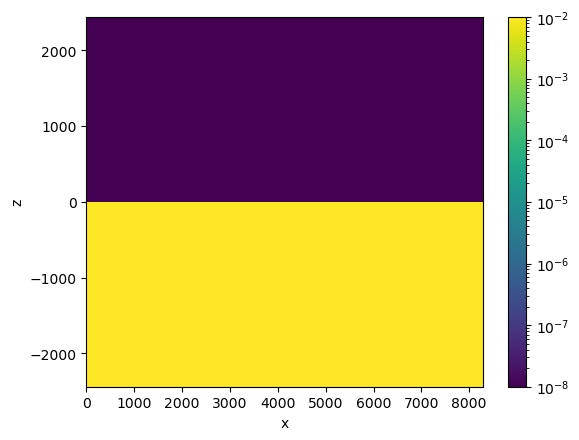

In [4]:
out = mesh.plot_image(sigma, pcolor_opts={'norm':LogNorm()})
plt.colorbar(out[0])

In [5]:
from SimPEG import utils
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from pymatsolver import PardisoSolver
# from pymatsolver import Solver

In [6]:
receiver_orientation = "z"                    # "x", "y" or "z"
z_src = 30
x_rx = 10.
z_offset = 0.
receiver_location = np.array([x_rx, 0., z_src+z_offset])
source_location = np.array([0., 0., z_src])
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 31)
rx = tdem.receivers.PointMagneticFluxTimeDerivative(
    receiver_location, times, orientation=receiver_orientation
)
receiver_list = [rx]
src = tdem.sources.MagDipole(
    receiver_list=receiver_list, location=source_location,
    waveform=tdem.sources.StepOffWaveform(), orientation='z'
)

# Survey
source_list = [src]
survey = tdem.Survey(source_list)
dts = np.diff(np.logspace(-7, -1, 60))
time_steps = []
for dt in dts:
    time_steps.append((dt, 1))

simulation_3d = SimulationAEM(
    mesh=mesh,
    survey=survey,
    sigmaMap=maps.IdentityMap(mesh),
    solver=PardisoSolver,
    time_steps=time_steps
)    
simulation_3d_test = tdem.Simulation3DMagneticFluxDensity(
    mesh=mesh,
    survey=survey,
    sigmaMap=maps.IdentityMap(mesh),
    solver=PardisoSolver,
    time_steps=time_steps    
)

In [7]:
%%time
data = simulation_3d.dpred(sigma)

/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:216: FutureWarning: CylMesh.edgeCurl has been deprecated, please use CylMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:264: FutureWarning: CylMesh.getInterpolationMat has been deprecated, please use CylMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/cylindrical_mesh.py:1679: FutureWarning: The locType keyword argument has been deprecated, please use location_type. This will be removed in discretize 1.0.0
  warnings.warn(
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/sgkang09/anaconda3/lib/

CPU times: user 3.71 s, sys: 1.26 s, total: 4.97 s
Wall time: 1.63 s


- sigma_local = Mapping(global_model)
- global_model: (Mx1); M > 1e6
- sigma_local; (M_local x 1); ~4e3

P_mappping @ global_model = sigma_local

[M_localxM; sparse matrix]

J_local (n_local x M_local)


J_local @ P_mapping = J

(J_local @ P_mapping) @ vec

(J_local @ P_mapping)^T @ vec

In [8]:
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    sigmaMap=maps.IdentityMap(nP=1),
)

# Predict data for a given model
sigma_1d =  np.ones(1) * sigma_background
data_analytic = simulation.dpred(sigma_1d)
data_analytic

array([-1.45108456e-07, -1.05172237e-07, -7.44227958e-08, -5.13277922e-08,
       -3.44554901e-08, -2.24932385e-08, -1.42755650e-08, -8.80996461e-09,
       -5.29053697e-09, -3.09497139e-09, -1.76633327e-09, -9.85087740e-10,
       -5.37835799e-10, -2.88010369e-10, -1.51550454e-10, -7.85016885e-11,
       -4.00973426e-11, -2.02282050e-11, -1.00934771e-11, -4.98821092e-12,
       -2.44448144e-12, -1.18914537e-12, -5.74785469e-13, -2.76280632e-13,
       -1.32161906e-13, -6.29601568e-14, -2.98825471e-14, -1.41402940e-14,
       -6.67398698e-15, -3.14087231e-15, -1.47632394e-15])

In [9]:
b0 = src.bInitial(simulation_3d)

In [10]:
from scipy.interpolate import interp1d

In [11]:
def bdf2(sigma):
    simulation_3d.model = sigma
    # Operators
    C = mesh.edgeCurl
    MfMui = simulation_3d.MfMui
    MeSigma = simulation_3d.MeSigma
    n_steps = simulation_3d.time_steps.size
    Fz = mesh.getInterpolationMat(rx.locations, locType='Fz')
    eps = 1e-10
    def getA(dt, factor=1.):
        return C.T*MfMui*C + factor/dt * MeSigma
    dt_0 = 0.
    sol = np.zeros((mesh.n_edges, simulation_3d.time_steps.size), order='F', dtype=float)
    data_test = np.zeros(simulation_3d.time_steps.size)
    # sol_n0 = np.zeros(mesh.nE)
    # sol_n1 = np.zeros(mesh.nE)
    # sol_n2 = np.zeros(mesh.nE)
    for tInd in range(n_steps):
        dt = simulation_3d.time_steps[tInd]
        #Factor for BDF2
        factor=3/2.            
        if abs(dt_0-dt) > eps:
            # print (tInd, factor)
            A = getA(dt, factor=factor)            
            Ainv = simulation_3d.solver(A)
        if tInd==0:        
            b0 = src.bInitial(simulation_3d)
            s_e = C.T*MfMui*b0
            rhs = factor/dt*s_e
        elif tInd==1:
            # rhs = -factor/dt*(MeSigma*(-4/3.*sol[:,tInd-1]+1/3.*sol[:,tInd-2]) + 1./3.*s_e)
            rhs = -factor/dt*(MeSigma*(-sol[:,tInd-1]))
        else:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol[:,tInd-1]+1/3.*sol[:,tInd-2]))
        sol[:,tInd] = Ainv*rhs
        data_test[tInd] = Fz*(-C*sol[:,tInd])
        dt_0 = dt
    data_test = (Fz@(-C@sol)).flatten()
    log10_time = np.log10(simulation_3d.time_mesh.cell_centers)
    ht = np.diff(log10_time)
    log10_time_mesh = TensorMesh([ht], x0=[log10_time[0]])
    Pt = log10_time_mesh.get_interpolation_matrix(np.log10(rx.times), location_type='N')        
    # step_func = interp1d(
    #     np.log10(simulation_3d.time_mesh.gridCC[:]), data_test
    # )
    # return step_func(np.log10(rx.times))
    data_bdf2 = Pt @ data_test
    return sol, data_bdf2

In [12]:
_, data_bdf2 = bdf2(sigma)

In [13]:
nD = rx.nD

In [14]:
# for src in source_list:
#     rx_list = src.receiver_list:
#     for rx in rx_list:
#         nD += rx.nD

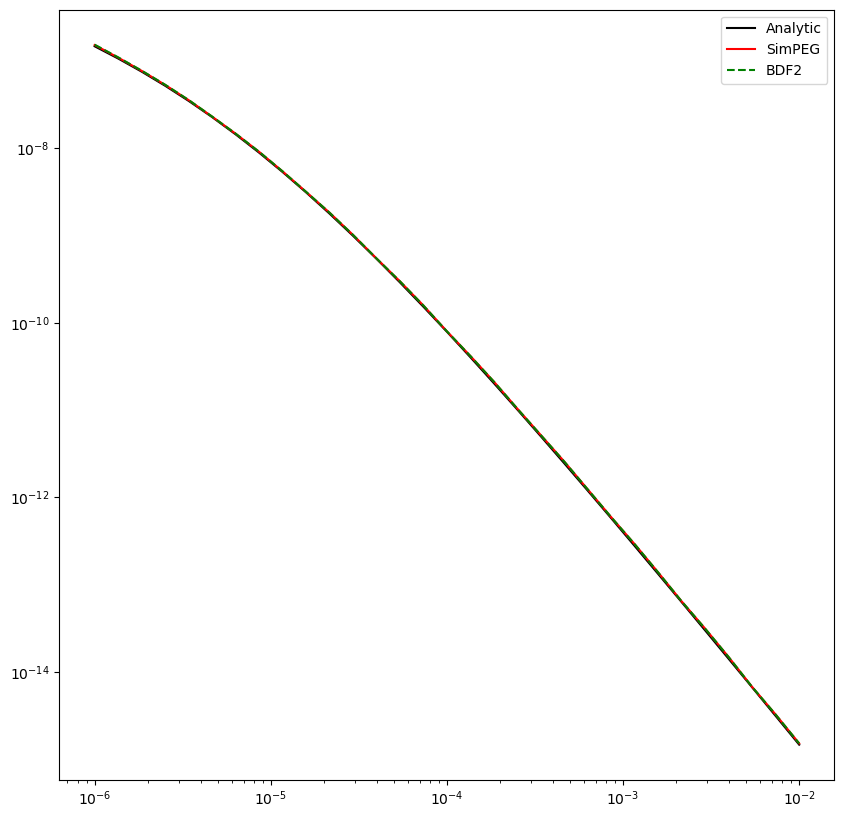

In [15]:
plt.figure(figsize = (10, 10))
plt.loglog(rx.times, -data_analytic, 'k')
plt.loglog(rx.times, -data, 'r')
plt.loglog(rx.times, -data_bdf2, 'g--')
plt.legend(("Analytic", "SimPEG", "BDF2"))
# plt.legend(("Analytic", "BDF1", "BDF2"))

In [28]:
C = mesh.edge_curl
log10_time = np.log10(simulation_3d.time_mesh.cell_centers)
ht = np.diff(log10_time)
log10_time_mesh = TensorMesh([ht], x0=[log10_time[0]])
Fz = mesh.get_interpolation_matrix(rx.locations, locType='Fz')
PtT = log10_time_mesh.get_interpolation_matrix(np.log10(rx.times), location_type='N').T.toarray()
# PtT = simulation_3d.time_mesh.get_interpolation_matrix(rx.times, location_type='CC').T.toarray()
PsT = -(Fz@C).T.toarray()

In [29]:
# n_time_steps x n_time_channels

In [30]:
from SimPEG import maps
active_map = maps.InjectActiveCells(mesh, indActive=active, valInactive=np.log(1e-8))
exp_map = maps.ExpMap(mesh)
mapping = exp_map * active_map

In [31]:
m = np.ones(active.sum()) * np.log(1./20.)
sigma = mapping * m

In [54]:
# %%time
# Let's rewrite derivation, and check. 
def getAdiag(self, tInd):
    """
    Diagonal of the system matrix at a given time index
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]
    C = self.mesh.edge_curl
    MfMui = self.MfMui
    MeSigma = self.MeSigma
    return C.T.tocsr() * (MfMui * C) + 1.0 / dt * MeSigma

def getAdiagDeriv(self, tInd, u, v, adjoint=False):
    """
    Deriv of ADiag with respect to electrical conductivity
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]
    # MeSigmaDeriv = self.MeSigmaDeriv(u)

    if adjoint:
        return 1.0 / dt * self.MeSigmaDeriv(u, v, adjoint)

    return 1.0 / dt * self.MeSigmaDeriv(u, v, adjoint)

def getAsubdiag(self, tInd):
    """
    Matrix below the diagonal
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]

    return -1.0 / dt * self.MeSigma

def getAsubdiagDeriv(self, tInd, u, v, adjoint=False):
    """
    Derivative of the matrix below the diagonal with respect to electrical
    conductivity
    """
    dt = self.time_steps[tInd]

    if adjoint:
        return -1.0 / dt * self.MeSigmaDeriv(u, v, adjoint)

    return -1.0 / dt * self.MeSigmaDeriv(u, v, adjoint)

def get_J_sigma_bdf1(sigma):
    simulation_3d.model = sigma
    C = mesh.edgeCurl
    n_steps = simulation_3d.time_steps.size
    eps = 1e-10
    nE = mesh.n_edges
    nD = rx.nD
    nT = len(simulation_3d.time_steps)
    nM = mesh.n_cells
    dt_0 = 0.
    nC = mesh.n_cells
    yn = np.zeros((nE, nD), dtype=float, order='F')
    yn_1 = np.zeros((nE, nD), dtype=float, order='F')
    J_matrixT = np.zeros((nM, nD), dtype=float, order='F')    
    sol, _ = bdf1(sigma)    
    for tInd in reversed(range(n_steps)):
        dt = simulation_3d.time_steps[tInd]
        A = getAdiag(simulation_3d, tInd)
        
        pn = (PsT * PtT[tInd, :])
        if abs(dt_0-dt) > eps:
            # print (tInd)
            Ainv = simulation_3d.solver(A)
        if tInd==n_steps-1:
            yn = Ainv * pn
        else:
            B = getAsubdiag(simulation_3d, tInd+1)
            yn = Ainv * (pn-B@yn_1)   
        dAT_dm = getAdiagDeriv(simulation_3d, tInd, sol[:,tInd], v=None, adjoint=True) @ yn
        dAsubdiagT_dm = getAsubdiagDeriv(simulation_3d, tInd, sol[:,tInd-1], v=None, adjoint=True) @ yn
        J_matrixT = J_matrixT + -dAT_dm - dAsubdiagT_dm
        yn_1 = yn
        dt_0 = dt
    return J_matrixT.T

In [55]:
# def getAdiag(self, tInd):
#     """
#     Diagonal of the system matrix at a given time index
#     """
#     assert tInd >= 0 and tInd < self.nT

#     dt = self.time_steps[tInd]
#     C = self.mesh.edge_curl
#     MfMui = self.MfMui
#     MeSigma = self.MeSigma
#     return C.T.tocsr() * (MfMui * C) + (3./2.) / dt * MeSigma

# def getAdiagDeriv(self, tInd, u, v, adjoint=False):
#     """
#     Deriv of ADiag with respect to electrical conductivity
#     """
#     assert tInd >= 0 and tInd < self.nT

#     dt = self.time_steps[tInd]
#     # MeSigmaDeriv = self.MeSigmaDeriv(u)

#     if adjoint:
#         return (3./2.) / dt * self.MeSigmaDeriv(u, v, adjoint)

#     return (3./2.) / dt * self.MeSigmaDeriv(u, v, adjoint)

# def getAsubdiag(self, tInd):
#     """
#     Matrix below the diagonal
#     """
#     assert tInd >= 0 and tInd < self.nT

#     dt = self.time_steps[tInd]

#     return -(4./3.) / dt * self.MeSigma

# def getAsubdiagDeriv(self, tInd, u, v, adjoint=False):
#     """
#     Derivative of the matrix below the diagonal with respect to electrical
#     conductivity
#     """
#     dt = self.time_steps[tInd]

#     if adjoint:
#         return -(4./3.) / dt * self.MeSigmaDeriv(u, v, adjoint)

#     return -(4./3.) / dt * self.MeSigmaDeriv(u, v, adjoint)

# def getAsubsubdiag(self, tInd):
#     """
#     Matrix below the subdiagonal
#     """
#     assert tInd >= 0 and tInd < self.nT

#     dt = self.time_steps[tInd]

#     return -(1./3.) / dt * self.MeSigma

# def getAsubsubdiagDeriv(self, tInd, u, v, adjoint=False):
#     """
#     Derivative of the matrix below the subdiagonal with respect to electrical
#     conductivity
#     """
#     dt = self.time_steps[tInd]

#     if adjoint:
#         return -(1./3.) / dt * self.MeSigmaDeriv(u, v, adjoint)

#     return -(1./3.) / dt * self.MeSigmaDeriv(u, v, adjoint)

# # %%time
# # Let's rewrite derivation, and check. 
# def get_J_sigma_bdf2(sigma):
#     simulation_3d.model = sigma
#     C = mesh.edgeCurl
#     n_steps = simulation_3d.time_steps.size
#     eps = 1e-10
#     nE = mesh.n_edges
#     nD = rx.nD
#     nT = len(simulation_3d.time_steps)
#     nM = mesh.n_cells
#     dt_0 = 0.
#     nC = mesh.n_cells
#     yn = np.zeros((nE, nD), dtype=float, order='F')
#     yn_1 = np.zeros((nE, nD), dtype=float, order='F')
#     J_matrixT = np.zeros((nM, nD), dtype=float, order='F')    
#     sol, _ = bdf2(sigma)    
#     for tInd in reversed(range(n_steps)):
#         dt = simulation_3d.time_steps[tInd]
#         A = getAdiag(simulation_3d, tInd)
        
#         pn = (PsT * PtT[tInd, :])
#         if abs(dt_0-dt) > eps:
#             # print (tInd)
#             Ainv = simulation_3d.solver(A)
#         if tInd==n_steps-1:
#             yn = Ainv * pn
#         else:
#             B = getAsubdiag(simulation_3d, tInd+1)
#             yn = Ainv * (pn-B@yn_1)   
#         dAT_dm = getAdiagDeriv(simulation_3d, tInd, sol[:,tInd], v=None, adjoint=True) @ yn
#         dAsubdiagT_dm = getAsubdiagDeriv(simulation_3d, tInd, sol[:,tInd-1], v=None, adjoint=True) @ yn
#         J_matrixT = J_matrixT + -dAT_dm - dAsubdiagT_dm
#         yn_1 = yn
#         dt_0 = dt
#     return J_matrixT.T

g1^T @ yn
[MxnE][nExnD]

J^T = G^T y = [g1^T, g2^T, g3^T] @  [y1, y2, y3]
 = g1^T @ y1 + g2^T @ y2 + ... + gn^T @ yn

In [46]:
%%time
J_sigma = get_J_sigma_bdf1(sigma)

CPU times: user 4.74 s, sys: 1.51 s, total: 6.25 s
Wall time: 611 ms


In [47]:
v = np.random.randn(rx.nD)

In [48]:
Jtv = simulation_3d_test.Jtvec(sigma, v)

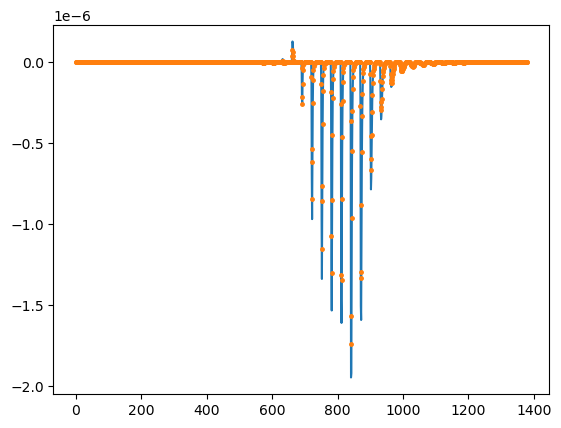

In [49]:
plt.plot(J_sigma.T @ v)
plt.plot(Jtv, '.', ms=5)

In [50]:
def dpred(m):
    sigma = mapping * m    
    _, dpred = bdf1(sigma)
    return dpred

def dpred_dm(m, obs):
    sigma = mapping * m
    uncert = abs(obs) * 0.03
    return utils.sdiag(1./uncert) @ get_J_sigma_bdf1(sigma) * mapping.deriv(m)

def data_misfit(m, obs):
    pred = dpred(m)
    uncert = abs(obs) * 0.03
    r = (pred-obs) / uncert
    return np.linalg.norm(r)**2

def data_misfit_dm(m, obs):
    pred = dpred(m)
    uncert = abs(obs) * 0.03
    r = (pred-obs) / uncert
    J = dpred_dm(m, obs)
    return 2*J.T@r

In [51]:
m_true = np.ones(active.sum()) * np.log(1./20.)
m_0 = m_true * 2

In [52]:
# Order test for BDF1 
factors = [0.1, 0.01, 0.001, 0.0001]
m_true = np.ones(active.sum()) * np.log(1./20.)
m_0 = m_true * 2

obs = dpred(m_true)
dm0 = m_0*2

order_1 = np.zeros(len(factors))
order_2 = np.zeros(len(factors))

for ii, factor in enumerate(factors):
    dm = dm0 * factor
    order_1[ii] = np.linalg.norm(
        data_misfit(m_0+dm, obs)-data_misfit(m_0, obs)
    )**2
    order_2[ii] = np.linalg.norm(
        data_misfit(m_0+dm, obs)-data_misfit(m_0, obs)-data_misfit_dm(m_0, obs).dot(dm.T)
    )**2
#     print (">> {:.1e}, {:.1e}, {:.1e}".format(factor, order_1[ii], order_2[ii]))
    if ii > 0:
        ratio_1 = order_1[ii]/order_1[ii-1]
        ratio_2 = order_2[ii]/order_2[ii-1]
        
        print (">> {:.1e}, {:.1e}, {:.1e}, {:.1f}".format(factor, order_1[ii], order_2[ii], np.log10(ratio_1/ratio_2)))
    else:
        print (">> {:.1e}, {:.1e}, {:.1e}, {:.1f}".format(factor, order_1[ii], order_2[ii], np.nan))

>> 1.0e-01, 2.0e+07, 1.3e+06, nan
>> 1.0e-02, 3.1e+05, 1.7e+02, 2.1
>> 1.0e-03, 3.2e+03, 1.8e-02, 2.0
>> 1.0e-04, 3.2e+01, 2.7e-06, 1.8


## Notes: 

- Using a combination of bdf2 - fwd and bdf1 - sensitivity does not provide the second order. 
- It seems the curruent SimPEG TDEM code has some errors. 

## TODOS: 
- Rederive equations for sensitivity-bdf1
- Derive equations for sensitivity-bdf2
- Implement sensitivity for bdf2
- Extension for a general waveform
- Extension for handling multiple sources
- Put together as a simiulation class
- Implementing a global simulation for inversion 

In [59]:
# def dpred(m):
#     return m**2 

# def dpred_dm(m):
#     return np.diag(2*m)

# def data_misfit(m, obs):
#     pred = dpred(m)
#     r = pred-obs 
#     return np.linalg.norm(r)**2

# def data_misfit_dm(m, obs):
#     pred = dpred(m)
#     r = pred-obs
#     J = dpred_dm(m)
#     return 2*J.T@r

In [60]:
# plt.plot(J_matrix.flatten())
# plt.plot(-JT.flatten())